# Set up the environment

Before running the notebook, please ensure the necessary packages are installed in the kernel environment where this notebook is running.
**Required packages:** See `requirements.txt`. Run `pip install -r requirements.txt` before executing this notebook. Alternatively, uncomment and
run the cell below to install packages manually. 


In [ ]:
""" %pip install python-dateutil
%pip install pandas
%pip install numpy
%pip install seaborn
%pip install matplotlib
%pip install earthengine-api --upgrade
%pip install geemap
%pip install xarray """

In [ ]:
from dateutil.relativedelta import relativedelta
from datetime import datetime

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import ee
import geemap
import xarray as xr

# Authenticate and Initialize Earth Engine
ee.Authenticate()
ee.Initialize(project= "ee-christopherharrellgis")

#Initialize Map
Map = geemap.Map()

### Data Imports

In [ ]:
# SOC samples table loaded from earth engine asset
soc_sample_points = ee.FeatureCollection("users/christopherharrellgis/soc_samples")

# Buffer sample points by 10km and return bounds
study_area = soc_sample_points.geometry().bounds().buffer(10000).bounds()

# Harmonized Sentinel-2 SR and Cloud Score
s2 = ee.ImageCollection('COPERNICUS/S2_SR')
s2CloudScore = ee.ImageCollection('GOOGLE/CLOUD_SCORE_PLUS/V1/S2_HARMONIZED')

# DEM
dem = ee.ImageCollection('COPERNICUS/DEM/GLO30')

# CHIRPS Daily
chirps = ee.ImageCollection('UCSB-CHG/CHIRPS/DAILY')

##### Define Global Variables

In [ ]:
# Start/End Dates
p1_start_date = "2022-03-01"
p1_end_date = "2023-02-28"
 
p2_start_date = "2023-03-01"
p2_end_date = "2024-02-29"

# Sentinel-2
S2_QA_BAND = "cs_cdf"
S2_CLEAR_THRESHOLD = 0.60
S2_SCALE_FACTOR = 0.0001

# Veg Indices Thresholds
NDVI_THRESHOLD = 0.4
EVI_THRESHOLD = 0.25
NIRv_THRESHOLD = 0.1
LAI_THRESHOLD = 2.0

In [ ]:
def temporal_filter(imageCollection, start_date, end_date):
    """ Filters an ImageCollection by start and end dates """
    return imageCollection.filterDate(start_date, end_date)

def spatial_filter(imageCollection, region):
    """ Filters an ImageCollection by region """
    return imageCollection.filterBounds(region)

def clip_to_roi(image):
    return image.clip(study_area)

def temporal_reducer(col):
    """ Reduces an ImageCollection over time by computing the mean, 10th and 90th percentiles, and standard deviation for each pixel. """
    reducer = ee.Reducer.mean() \
    .combine(ee.Reducer.percentile([10, 90]), sharedInputs = True) \
    .combine(ee.Reducer.stdDev(), sharedInputs = True)
    return col.reduce(reducer) 


#### Sentinel-2 processing

In [ ]:
def s2_cloud_mask(image):
    #Applies a cloud mask based on the QA band using a threshold to identify clear pixels.#
    return image.select(S2_QA_BAND).gte(S2_CLEAR_THRESHOLD)

def calc_ndvi_s2(image):
    #Calculates the Normalized Difference Vegetation Index (NDVI) from NIR and Red bands.#
    return image.normalizedDifference(['B8', 'B4']).rename('NDVI')

def calc_evi_s2(image):
    #Calculates the Enhanced Vegetation Index (EVI) from an image and returns it as a single-band image named 'EVI'.#
    return image.expression(
        '2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1))',
        {
            'NIR': image.select('B8'),
            'RED': image.select('B4'),
            'BLUE': image.select('B2')
        }
    ).rename('EVI')

def calc_nirv_s2(image):
    ndvi = calc_ndvi_s2(image)
    nir = image.select('B8')
    return nir.multiply(ndvi).rename('NIRv')

def calc_lai_s2(image):
    evi = calc_evi_s2(image)
    return evi.expression('3.618 * EVI - 0.118', {'EVI': evi}).rename('LAI')

def calc_veg_indices_s2(image):
    #Adds multiple vegetation and water indices (NDVI, EVI, NDWI, MNDWI, SAVI) as bands to the image.
    return image.addBands(
        [calc_ndvi_s2(image), calc_evi_s2(image), calc_nirv_s2(image), calc_lai_s2(image)]
    )

def process_s2_image(image):
    #Processes Sentinel-2 SR image to apply cloud masking, scale, and add NDVI, EVI, NIRv, and LAI.
    original = image
    mask = s2_cloud_mask(image)
    image = image.select([
        "B2", "B3", "B4", "B5", "B6", "B7", "B8", "B8A", "B11", "B12"]
    ).multiply(S2_SCALE_FACTOR)

    indices = calc_veg_indices_s2(image).updateMask(mask)
    return indices.copyProperties(original, ["system:time_start"])

def link_s2_collections(col1, col2):
    #Links a secondary collection (e.g., QA) to a primary Sentinel-2 collection by matching and attaching specified bands.#
    linked_collection = col1.linkCollection(col2, [S2_QA_BAND])
    return linked_collection

#### CHIRPS Precip Processing

In [ ]:
def mean_daily_precip_series(start_date, end_date):
    #Returns a time series of daily precipitation means using CHIRPS data.#
    filtered = chirps.filterDate(start_date, end_date)
    def extract_mean(img):
        stat = img.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=study_area,
            scale=5000,
            maxPixels=1e13
        )
        return ee.Feature(None, {'date': img.date().format('YYYY-MM-dd'), 'precip': stat.get('precipitation')})
    return ee.FeatureCollection(filtered.map(extract_mean))

def plot_mean_daily_precip(feature_collection):
    #Plots mean daily precipitation from a FEatureCollection of summary statistics.#
    features = feature_collection.getInfo()['features']
    data = [{'date': f['properties']['date'], 'precip': f['properties']['precip']} for f in features]

    df = pd.DataFrame(data)
    df['date'] = pd.to_datetime(df['date'])
    df['precip'] = pd.to_numeric(df['precip'], errors='coerce')

    years = sorted(df['date'].dt.year.unique())

    plt.figure(figsize=(14, 5))
    sns.lineplot(data=df, x='date', y='precip')

    plt.axvline(pd.to_datetime(f'{years[0]}-03-15'), color='green', linestyle='--', label='Long Rains')
    plt.axvline(pd.to_datetime(f'{years[0]}-06-01'), color='green', linestyle='--')

    plt.axvline(pd.to_datetime(f'{years[0]}-10-15'), color='blue', linestyle='--', label='Short Rains')
    plt.axvline(pd.to_datetime(f'{years[0]}-12-31'), color='blue', linestyle='--')

    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    plt.xticks(rotation=45)

    plt.title('Daily Mean Precipitation (CHIRPS)')
    plt.xlabel('Date')
    plt.ylabel('Precipitation (mm)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Convert to pandas DataFrames
def fc_to_df(fc, period_label):
    features = fc.getInfo()['features']
    data = [{'date': f['properties']['date'], 'precip': f['properties']['precip']} for f in features]
    df = pd.DataFrame(data)
    df['date'] = pd.to_datetime(df['date'])
    df['precip'] = pd.to_numeric(df['precip'], errors='coerce')
    df['period'] = period_label
    return df
    

In [ ]:

daily_precip_fc_p1 = mean_daily_precip_series(p1_start_date, p1_end_date)
daily_precip_fc_p2 = mean_daily_precip_series(p2_start_date, p2_end_date)

df_p1 = fc_to_df(daily_precip_fc_p1, '2022-2023')
df_p2 = fc_to_df(daily_precip_fc_p2, '2023-2024')
df_all = pd.concat([df_p1, df_p2])

# Set up plot
plt.figure(figsize=(14, 6))
sns.lineplot(data=df_all, x='date', y='precip', hue='period')

plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45)

# Format plot
plt.title('Daily Mean Precipitation Comparison (CHIRPS)')
plt.xlabel('Date')
plt.ylabel('Precipitation (mm)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
def calc_sum_precip(col):
    """ Calculates annual total precipitation for a given year.
    Returns ee.Image
     """
    reducer = ee.Reducer.sum()
    img = col.reduce(reducer)
    return img.select("precipitation_sum").rename('TOTAL_PRECIP')

def monthly_total_precip(col, start_date, end_date):
    """ Calculates total monthly precipitation between start and end dates using CHIRPS data.
    
    Returns ee.ImageCollection """
    
    start_dt = datetime.strptime(start_date, '%Y-%m-%d').date()
    end_dt = datetime.strptime(end_date, '%Y-%m-%d').date()

    monthly_images = []

    current = start_dt
    while current < end_dt:
        next_month = current + relativedelta(months=1)
        month_str = current.strftime('%b').upper()

        filtered = temporal_filter(col, current.isoformat(), next_month.isoformat())
        band_name = f"{current.year}_{current.strftime('%b').upper()}_TOTAL_PRECIP"
        reducer = ee.Reducer.sum()
        img = filtered.reduce(reducer).select("precipitation_sum").rename(band_name)
        monthly_images.append(img)
        current = next_month

    return ee.ImageCollection(monthly_images)

def mean_daily_precip_series(start_date, end_date):
    #Returns a time series of daily precipitation means using CHIRPS data.#
    filtered = chirps.filterDate(start_date, end_date)
    def extract_mean(img):
        stat = img.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=study_area,
            scale=5000,
            maxPixels=1e13
        )
        return ee.Feature(None, {'date': img.date().format('YYYY-MM-dd'), 'precip': stat.get('precipitation')})
    return ee.FeatureCollection(filtered.map(extract_mean))

def monthly_total_precip_series(start_date, end_date):
    #Returns a time series of monthly precipitation means using CHIRPS data.#
    monthly_precip = monthly_precip_filter(start_date, end_date)

    band_names = monthly_precip.bandNames()

    def band_to_feature(band_name):
        band = ee.String(band_name)
        image = monthly_precip.select([band])
        mean_dict = image.reduceRegion(
            reducer=ee.Reducer.sum(),
            geometry=study_area,
            scale=5566,  # approx. CHIRPS resolution (~5.5km)
            maxPixels=1e13
        )
        return ee.Feature(None, mean_dict).set('month', band)

    features = band_names.map(lambda name: band_to_feature(name))
    return ee.FeatureCollection(features)


#### Processing Remote Sensing Data

In [130]:
# Sentinel-2 SR
s2 = spatial_filter(s2, study_area)

# P1
s2_p1 = temporal_filter(s2, p1_start_date, p1_end_date)
s2_linked_p1 = link_s2_collections(s2_p1, s2CloudScore)
s2_processed_p1 = s2_linked_p1.map(process_s2_image)

s2_ndvi_p1 = s2_processed_p1.map(lambda img: img.clip(study_area)).select('NDVI')
s2_evi_p1 = s2_processed_p1.map(lambda img: img.clip(study_area)).select('EVI')
s2_nirv_p1 = s2_processed_p1.map(lambda img: img.clip(study_area)).select('NIRv')
s2_lai_p1 = s2_processed_p1.map(lambda img: img.clip(study_area)).select('LAI')

# P2
s2_p2 = temporal_filter(s2, p2_start_date, p2_end_date)
s2_linked_p2 = link_s2_collections(s2_p2, s2CloudScore)
s2_processed_p2 = s2_linked_p2.map(process_s2_image)

s2_ndvi_p2 = s2_processed_p2.map(lambda img: img.clip(study_area)).select('NDVI')
s2_evi_p2 = s2_processed_p2.map(lambda img: img.clip(study_area)).select('EVI')
s2_nirv_p2 = s2_processed_p2.map(lambda img: img.clip(study_area)).select('NIRv')
s2_lai_p2 = s2_processed_p2.map(lambda img: img.clip(study_area)).select('LAI')

# CHIRPS
chirps = spatial_filter(chirps, study_area)



In [ ]:
def resample_monthly_mean(
    col,
    geometry = study_area,
    scale: float = 0.00027,
    crs: str = 'EPSG:4326',
) -> xr.Dataset:
    """
    Opens an Earth Engine-exported image collection and computes monthly mean composites.

    Returns:
        Monthly mean-resampled dataset or variable DataArray.
    """
    ds = xr.open_dataset(col, engine='ee', crs=crs, scale=scale, geometry=geometry)
    ds = ds.sortby('time')
    monthly_mean = ds.resample(time='M').mean('time')
    return monthly_mean

#### NDVI

In [ ]:
p1_monthly_ndvi = resample_monthly_mean(s2_ndvi_p1)
#p1_monthly_ndvi.NDVI.plot(x='lon', y='lat', col='time', col_wrap=4, robust=True)

p2_monthly_ndvi = resample_monthly_mean(s2_ndvi_p2)
#p2_monthly_ndvi.NDVI.plot(x='lon', y='lat', col='time', col_wrap=4, robust=True)

#### EVI

In [ ]:
p1_monthly_evi = resample_monthly_mean(s2_evi_p1)
#p1_monthly_evi.EVI.plot(x='lon', y='lat', col='time', col_wrap=4, robust=True)

p2_monthly_evi = resample_monthly_mean(s2_evi_p2)
#p1_monthly_evi.EVI.plot(x='lon', y='lat', col='time', col_wrap=4, robust=True)

#### NIRv

In [ ]:
p1_monthly_nirv = resample_monthly_mean(s2_nirv_p1)
#p1_monthly_nirv.NIRv.plot(x='lon', y='lat', col='time', col_wrap=4, robust=True)

p2_monthly_nirv = resample_monthly_mean(s2_nirv_p2)
#p1_monthly_nirv.NIRv.plot(x='lon', y='lat', col='time', col_wrap=4, robust=True)

#### LAI

In [ ]:
p1_monthly_lai = resample_monthly_mean(s2_lai_p1)
#p1_monthly_lai.LAI.plot(x='lon', y='lat', col='time', col_wrap=4, robust=True)

p2_monthly_lai = resample_monthly_mean(s2_lai_p2)
#p1_monthly_lai.LAI.plot(x='lon', y='lat', col='time', col_wrap=4, robust=True)

In [ ]:
def spatial_mean_timeseries(
    dataset: xr.Dataset,
    spatial_dims: list = ['lon', 'lat'],
) -> pd.DataFrame:
    """
    Computes the spatial mean of a resampled dataset and returns a time series DataFrame.
    """
    variable_name = list(dataset.data_vars)[0]
    timeseries = dataset[variable_name].mean(dim=spatial_dims)
    df = timeseries.to_dataframe(name=variable_name).reset_index()
    return df

In [ ]:
p1_ndvi_timeseries = spatial_mean_timeseries(p1_monthly_ndvi)
p1_evi_timeseries = spatial_mean_timeseries(p1_monthly_evi)
p1_nirv_timeseries = spatial_mean_timeseries(p1_monthly_nirv)
p1_lai_timeseries = spatial_mean_timeseries(p1_monthly_lai)

p2_ndvi_timeseries = spatial_mean_timeseries(p2_monthly_ndvi)
p2_evi_timeseries = spatial_mean_timeseries(p2_monthly_evi)
p2_nirv_timeseries = spatial_mean_timeseries(p2_monthly_nirv)
p2_lai_timeseries = spatial_mean_timeseries(p2_monthly_lai)

# Merge all p1 dataframes on 'time'
df_p1 = p1_ndvi_timeseries.merge(p1_evi_timeseries, on='time', how='inner') \
                          .merge(p1_nirv_timeseries, on='time', how='inner') \
                          .merge(p1_lai_timeseries,  on='time', how='inner')

df_p1.columns = ['time', 'NDVI', 'EVI', 'NIRv', 'LAI']

df_p2 = p2_ndvi_timeseries.merge(p2_evi_timeseries, on='time', how='inner') \
                          .merge(p2_nirv_timeseries, on='time', how='inner') \
                          .merge(p2_lai_timeseries,  on='time', how='inner')

df_p2.columns = ['time', 'NDVI', 'EVI', 'NIRv', 'LAI']

In [57]:
p1_indices = df_p1.melt(id_vars='time', var_name='Index', value_name='Value')
p2_indices = df_p2.melt(id_vars='time', var_name='Index', value_name='Value')

In [ ]:
def plot_monthly_indices(df):
    """ 
    Plots tidy monthly vegetation index time series with formatted x-axis and automatic title.

    Parameters:
    - df: pandas.DataFrame with columns ['time', 'Index', 'Value']
     """
    # Ensure 'time' is datetime
    df['time'] = pd.to_datetime(df['time'])

    # Extract time range for title
    start_label = df['time'].min().strftime('%b %Y')
    end_label = df['time'].max().strftime('%b %Y')
    title = f'Monthly Vegetation Indices ({start_label} – {end_label})'

    # Plot
    plt.figure(figsize=(14, 5))
    sns.lineplot(data=df, x='time', y='Value', hue='Index')
    plt.title(title)
    plt.xlabel('Month')
    plt.ylabel('Index Value')
    plt.grid(True)

    # Format x-axis ticks to show all months
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

    plt.tight_layout()
    plt.show()

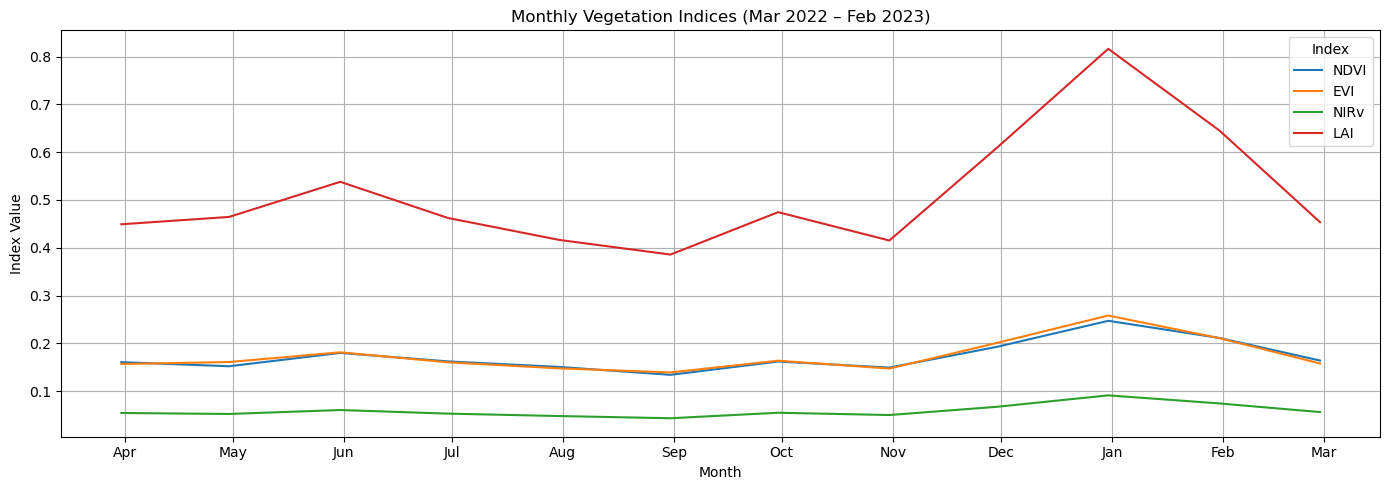

In [ ]:
plot_monthly_indices(p1_indices)

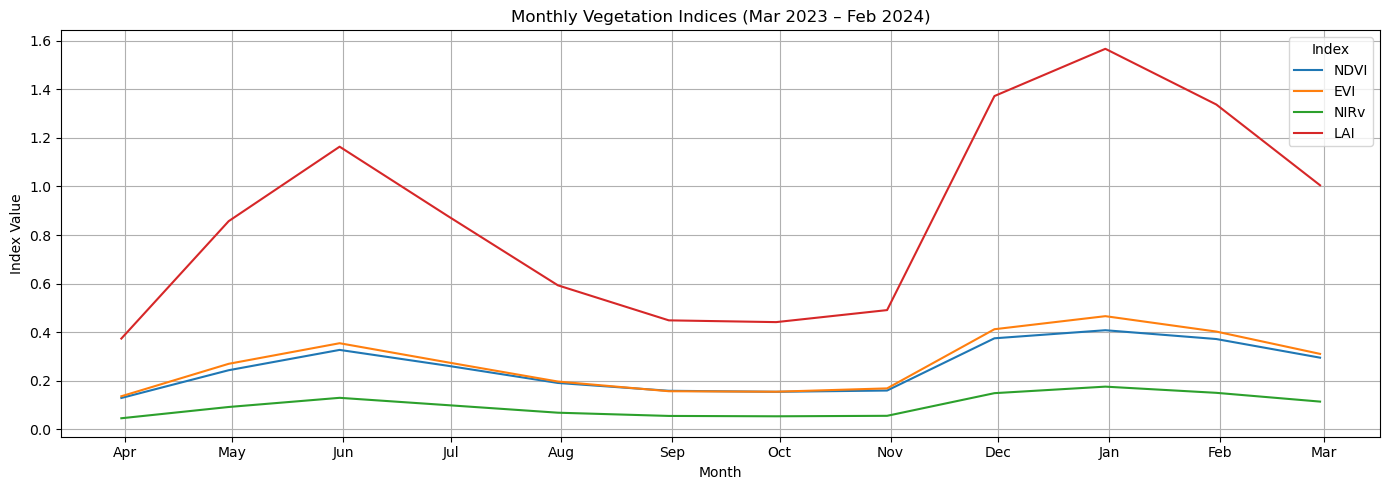

In [ ]:
plot_monthly_indices(p2_indices)

In [ ]:
def flag_above_threshold(df_tidy, index_name, threshold):
    #Returns a DataFrame with a flag for index values above the threshold.#
    df = df_tidy[df_tidy['Index'] == index_name].copy()
    df['above_thresh'] = df['Value'] > threshold
    return df

def compute_onset_duration(flagged_df):
    #Returns onset (first date), offset (last date), and duration.#
    active = flagged_df[flagged_df['above_thresh']]
    if active.empty:
        return None, None, 0
    onset = active['time'].min()
    offset = active['time'].max()
    duration = int(round((offset - onset) / pd.Timedelta(days=30))) + 1
    return onset, offset, duration

metrics = []

for df_index, label in [(p1_indices, '2022-2023'), (p2_indices, '2023-2024')]:
    for index, threshold in [('NDVI', NDVI_THRESHOLD), ('EVI', EVI_THRESHOLD), ('NIRv', NIRv_THRESHOLD), ('LAI', LAI_THRESHOLD)]:
        flagged = flag_above_threshold(df_index, index, threshold)
        onset, offset, duration = compute_onset_duration(flagged)
        metrics.append({
            'Period': label,
            'Index': index,
            'Threshold': threshold,
            'Onset': onset,
            'Offset': offset,
            'Duration (months)': duration
        })

# Convert to DataFrame
phenology_summary = pd.DataFrame(metrics)
phenology_summary

,Period,Index,Threshold,Onset,Offset,Duration (months)
0,2022-2023,NDVI,0.40,NaT,NaT,0
1,2022-2023,EVI,0.25,2022-12-31,2022-12-31,1
2,2022-2023,NIRv,0.10,NaT,NaT,0
3,2022-2023,LAI,2.00,NaT,NaT,0
4,2023-2024,NDVI,0.40,2023-12-31,2023-12-31,1
5,2023-2024,EVI,0.25,2023-04-30,2024-02-29,11
6,2023-2024,NIRv,0.10,2023-05-31,2024-02-29,10
7,2023-2024,LAI,2.00,NaT,NaT,0


In [ ]:
def plot_index_with_phenology(df_tidy, phenology_df, period_label):
    """ 
    Plots vegetation index time series for a given period, with shaded onset–offset rectangles.

    Parameters:
    - df_tidy: tidy DataFrame with ['time', 'Index', 'Value']
    - phenology_df: DataFrame with ['Index', 'Period', 'Onset', 'Offset']
    - period_label: string to match the correct period (e.g. '2022–2023')
     """
    # Filter time series and phenology summary for this period
    df = df_tidy.copy()
    df['time'] = pd.to_datetime(df['time'])
    phen = phenology_df[phenology_df['Period'] == period_label].copy()

    # Setup plot
    plt.figure(figsize=(14, 5))
    sns.lineplot(data=df, x='time', y='Value', hue='Index')
    
    # Add shaded rectangles for onset–offset periods
    for _, row in phen.iterrows():
        if pd.isnull(row['Onset']) or pd.isnull(row['Offset']):
            continue  # skip if no threshold crossing
        plt.axvspan(row['Onset'], row['Offset'], alpha=0.2, label=f"{row['Index']} active", color=None)

    # Format
    plt.title(f'Phenological Onset and Duration: {period_label}')
    plt.xlabel('Month')
    plt.ylabel('Index Value')
    plt.grid(True)

    # Format x-axis ticks
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

    plt.tight_layout()
    plt.legend()
    plt.show()

plot_index_with_phenology(p1_indices, phenology_summary, '2022-2023')
plot_index_with_phenology(p2_indices, phenology_summary, '2023-2024')

In [ ]:
def plot_phenology_with_rainfall(df_tidy, phenology_df, precip_df, period_label):
    """ 
    Plots vegetation indices with phenological onset-offset periods and daily rainfall on secondary y-axis.

    Parameters:
    - df_tidy: tidy DataFrame with ['time', 'Index', 'Value']
    - phenology_df: DataFrame with ['Index', 'Period', 'Onset', 'Offset']
    - precip_df: DataFrame with ['date', 'precip'] for the same period
    - period_label: string to label the plot (e.g. '2022–2023')
     """
    # Ensure datetime formats
    df = df_tidy.copy()
    df['time'] = pd.to_datetime(df['time'])
    precip_df['date'] = pd.to_datetime(precip_df['date'])

    # Get distinct colors for each index
    indices = df['Index'].unique()
    palette = dict(zip(indices, sns.color_palette("Set2", len(indices))))

    # Start plot
    fig, ax1 = plt.subplots(figsize=(14, 6))

    # Plot vegetation indices on left axis
    for index in indices:
        subset = df[df['Index'] == index]
        ax1.plot(subset['time'], subset['Value'], label=index, color=palette[index])

    # Shade onset-offset periods
    phen = phenology_df[phenology_df['Period'] == period_label]
    for _, row in phen.iterrows():
        if pd.isnull(row['Onset']) or pd.isnull(row['Offset']):
            continue
        ax1.axvspan(row['Onset'], row['Offset'], alpha=0.2, color=palette[row['Index']], label=f"{row['Index']} active")

    ax1.set_xlabel('Month')
    ax1.set_ylabel('Index Value')
    ax1.set_title(f'Phenological Periods and Rainfall ({period_label})')
    ax1.grid(True)

    # Format x-axis ticks
    ax1.xaxis.set_major_locator(mdates.MonthLocator())
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

    # Create right y-axis for rainfall
    ax2 = ax1.twinx()
    ax2.plot(precip_df['date'], precip_df['precip'], color='blue', alpha=0.3, label='Precipitation')
    ax2.set_ylabel('Precipitation (mm)', color='blue')
    ax2.tick_params(axis='y', labelcolor='blue')

    # Combine legends
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

    plt.tight_layout()
    plt.show()

In [ ]:
def feature_collection_to_precip_df(fc):
    """ 
    Converts a daily precipitation FeatureCollection to a pandas DataFrame.

    Parameters:
    - fc: ee.FeatureCollection with 'date' and 'precip' properties

    Returns:
    - DataFrame with ['date', 'precip']
     """
    features = fc.getInfo()['features']
    data = [{'date': f['properties']['date'], 'precip': f['properties']['precip']} for f in features]
    df = pd.DataFrame(data)
    df['date'] = pd.to_datetime(df['date'])
    df['precip'] = pd.to_numeric(df['precip'], errors='coerce')
    return df

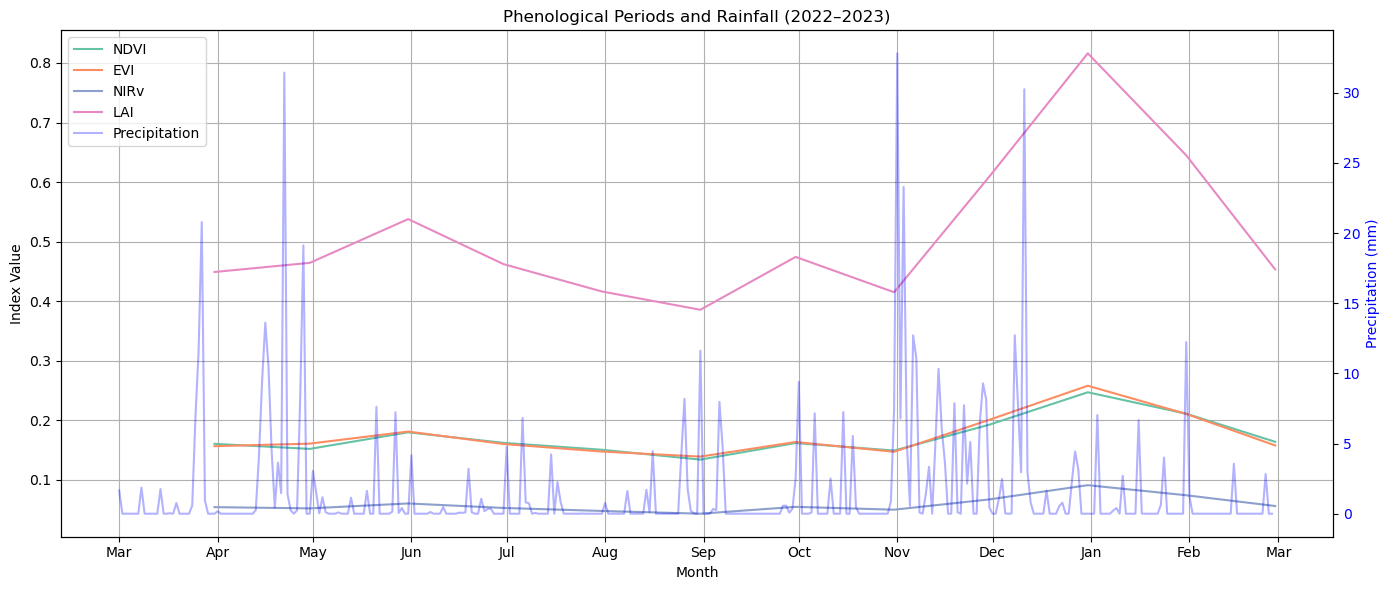

In [ ]:
p1_precip_df = feature_collection_to_precip_df(daily_precip_fc_p1)
plot_phenology_with_rainfall(p1_indices, phenology_summary, p1_precip_df, '2022-2023')

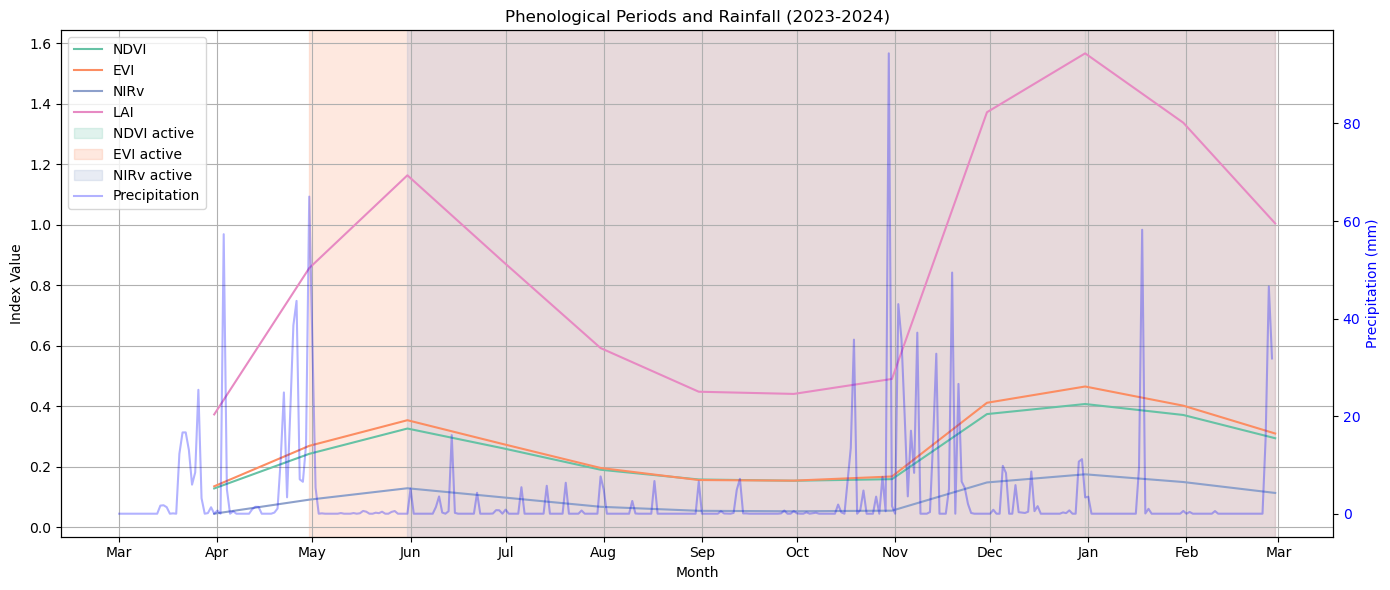

In [81]:
p2_precip_df = feature_collection_to_precip_df(daily_precip_fc_p2)
plot_phenology_with_rainfall(p2_indices, phenology_summary, p2_precip_df, '2023-2024')